In [1]:
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumikrakshit/nyu-depth-v2")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nyu-depth-v2


In [3]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [4]:
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, csv_filename, transform=None, depth_transform=None):
        """
        Args:
            root_dir (str): The root directory (e.g., 'dataset_root = path') where the dataset is located.
            csv_filename (str): CSV file name (e.g., "nyu2_train.csv" or "nyu2_test.csv") located in "nyu_data/data/".
            transform (callable, optional): Transformations for the color images.
            depth_transform (callable, optional): Transformations for the depth maps.
        """
        # Build the full path to the CSV file.
        csv_path = os.path.join(root_dir, "nyu_data", "data", csv_filename)

        # Read the CSV file using comma as delimiter.
        df = pd.read_csv(csv_path, header=None)

        # Debug: Print CSV shape and head.
        print("CSV DataFrame shape:", df.shape)
        print("CSV DataFrame head:\n", df.head())

        # If there are three columns (an unwanted index), drop the first column.
        if df.shape[1] == 3:
            print("Dropping the extra index column from CSV.")
            df = df.iloc[:, 1:3]

        # Reset index for safe access.
        self.samples = df.reset_index(drop=True)
        print("Final CSV shape used:", self.samples.shape)

        self.root_dir = root_dir  # e.g., dataset_root = path
        self.transform = transform
        self.depth_transform = depth_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Get relative paths from CSV for color and depth images.
        color_rel_path = self.samples.iloc[idx, 0]
        depth_rel_path = self.samples.iloc[idx, 1]

        # IMPORTANT: Prepend "nyu_data" to build the correct absolute paths.
        color_path = os.path.join(self.root_dir, "nyu_data", color_rel_path)
        depth_path = os.path.join(self.root_dir, "nyu_data", depth_rel_path)

        # Open the images.
        color_image = Image.open(color_path).convert('RGB')
        depth_image = Image.open(depth_path).convert('L')

        # Apply transformations, if provided.
        if self.transform:
            color_image = self.transform(color_image)
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)
        else:
            depth_image = transforms.ToTensor()(depth_image)

        return color_image, depth_image

# Sample transforms for the color images and depth maps.
color_transforms = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

depth_transforms = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.ToTensor()
])

# Assume dataset_root is already defined as path
dataset_root = path

# Create training and test dataset instances.
train_dataset = NYUDepthDataset(
    root_dir=dataset_root,
    csv_filename="nyu2_train.csv",
    transform=color_transforms,
    depth_transform=depth_transforms
)

test_dataset = NYUDepthDataset(
    root_dir=dataset_root,
    csv_filename="nyu2_test.csv",
    transform=color_transforms,
    depth_transform=depth_transforms
)

# Optionally, split the training dataset into training and validation sets.
batch_size = 16
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders.
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Number of training samples:", len(train_subset))
print("Number of validation samples:", len(val_subset))
print("Number of test samples:", len(test_dataset))

CSV DataFrame shape: (50688, 2)
CSV DataFrame head:
                                               0  \
0   data/nyu2_train/living_room_0038_out/37.jpg   
1  data/nyu2_train/living_room_0038_out/115.jpg   
2    data/nyu2_train/living_room_0038_out/6.jpg   
3   data/nyu2_train/living_room_0038_out/49.jpg   
4  data/nyu2_train/living_room_0038_out/152.jpg   

                                              1  
0   data/nyu2_train/living_room_0038_out/37.png  
1  data/nyu2_train/living_room_0038_out/115.png  
2    data/nyu2_train/living_room_0038_out/6.png  
3   data/nyu2_train/living_room_0038_out/49.png  
4  data/nyu2_train/living_room_0038_out/152.png  
Final CSV shape used: (50688, 2)
CSV DataFrame shape: (654, 2)
CSV DataFrame head:
                                  0                               1
0  data/nyu2_test/00000_colors.png  data/nyu2_test/00000_depth.png
1  data/nyu2_test/00001_colors.png  data/nyu2_test/00001_depth.png
2  data/nyu2_test/00008_colors.png  data/nyu2_test/0000

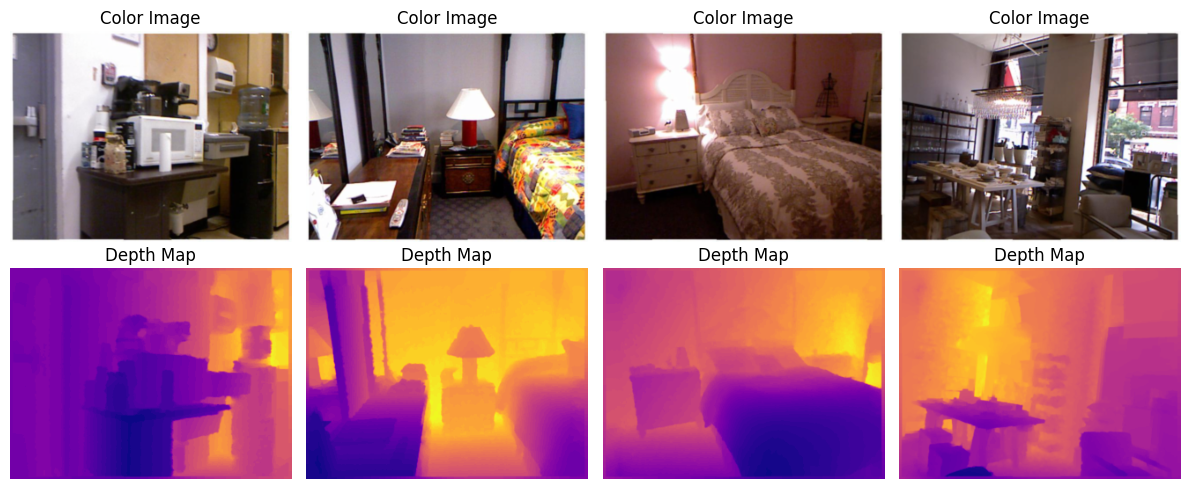

In [5]:
import matplotlib.pyplot as plt
import torchvision

def visualize_batch(data_loader, num_images=4):
    """
    Visualizes a few samples from the given DataLoader.

    Args:
        data_loader (DataLoader): DataLoader for the dataset (e.g., train_loader).
        num_images (int): Number of images to visualize (must be <= batch size).
    """
    # Fetch one batch
    color_images, depth_maps = next(iter(data_loader))

    # Clamp num_images to available samples
    num_images = min(num_images, color_images.size(0))

    plt.figure(figsize=(12, 5))

    for i in range(num_images):
        # Color image
        plt.subplot(2, num_images, i + 1)
        img = color_images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
        img = img.clip(0, 1)
        plt.imshow(img)
        plt.title("Color Image")
        plt.axis("off")

        # Depth map
        plt.subplot(2, num_images, i + 1 + num_images)
        depth = depth_maps[i].squeeze(0).cpu().numpy()
        plt.imshow(depth, cmap='plasma')  # better contrast
        plt.title("Depth Map")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_batch(train_loader, num_images=4)

# MiDAS

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
for x in tqdm(test_loader):
    color_images, depth_maps = x
    break

print(color_images.shape)
print(depth_maps.shape)

  0%|          | 0/41 [00:01<?, ?it/s]

torch.Size([16, 3, 240, 320])
torch.Size([16, 1, 240, 320])


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

MiDaS Small Model Evaluation on NYU Depth Dataset:
Average RMSE: 0.2746
Average MAE: 0.2154
Average AbsRel: 1.0291
Average SqRel: 0.5928
Average δ1 (% < 1.25): 0.2340


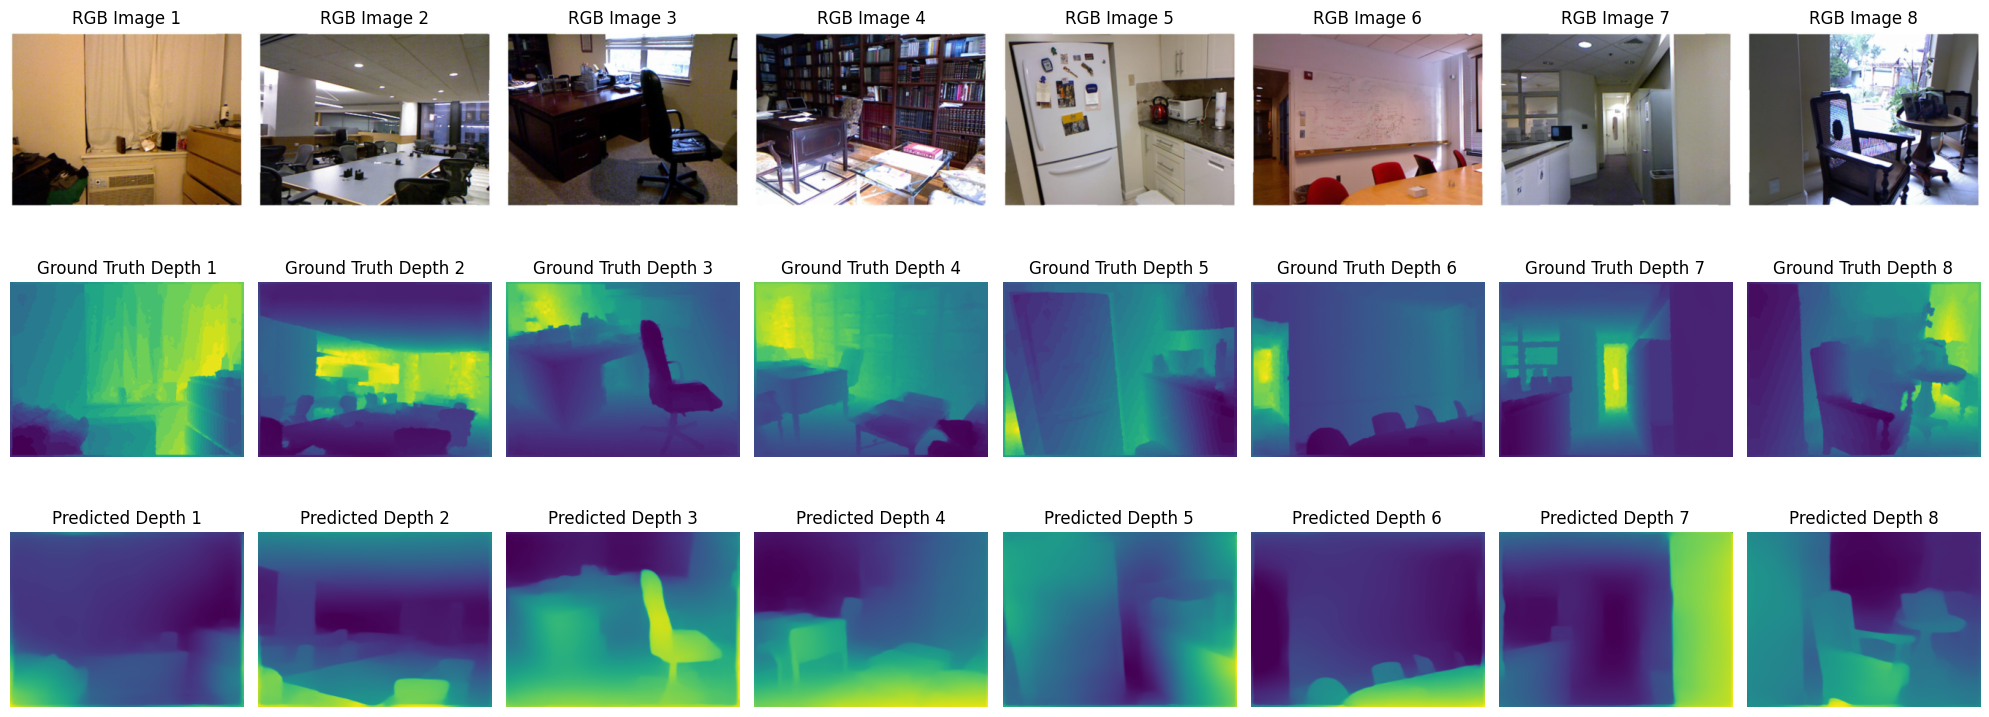

In [6]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchvision import transforms as T

# Assume device is already defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MiDaS model
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas.to(device)
midas.eval()


preprocess = T.Compose([
    T.Resize((256, 256)),
])

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Metrics to track
rmse_values = []
mae_values = []
abs_rel_values = []
sq_rel_values = []
delta1_values = []  # Threshold accuracy: % of pixels with ratio between 1.25^-1 and 1.25

# Visualize some results
all_rgb_images = []
all_gt_depths = []
all_pred_depths = []

with torch.no_grad():
    for idx, batch in enumerate(tqdm(train_loader)):
        color_images, gt_depth = batch
        batch_size = color_images.shape[0]

        # Store original images for visualization
        for i in range(batch_size):
            if len(all_rgb_images) < 8:  # Store only first 8 images
                all_rgb_images.append(denormalize(color_images[i]).cpu())
                all_gt_depths.append(gt_depth[i].squeeze().cpu())

        # Resize images to 256x256 for MiDaS
        resized_images = torch.zeros((batch_size, 3, 256, 256), device=device)
        for i in range(batch_size):
            img = preprocess(color_images[i])
            resized_images[i] = img

        # Move to device
        resized_images = resized_images.to(device)
        gt_depth = gt_depth.to(device)

        # Forward pass
        pred_depth = midas(resized_images)

        # Resize prediction to match ground truth size (240x320)
        pred_depth = F.interpolate(
            pred_depth.unsqueeze(1),
            size=gt_depth.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze(1)

        # Store predictions for visualization
        if idx == 0:
            for i in range(min(batch_size, 8)):
                all_pred_depths.append(pred_depth[i].cpu())

        # Calculate metrics for this batch
        for i in range(batch_size):
            gt_sample = gt_depth[i].squeeze()
            pred_sample = pred_depth[i]

            # Remove invalid pixels
            mask = gt_sample > 0
            if mask.sum() > 0:
                gt_masked = gt_sample[mask]
                pred_masked = pred_sample[mask]

                # Scale factor: median scaling
                scale = torch.median(gt_masked) / torch.median(pred_masked)
                pred_masked = pred_masked * scale

                # Calculate metrics
                gt_np = gt_masked.cpu().numpy()
                pred_np = pred_masked.cpu().numpy()

                # RMSE and MAE
                mae = mean_absolute_error(gt_np, pred_np)
                rmse = np.sqrt(mean_squared_error(gt_np, pred_np))

                # Relative errors
                abs_rel = torch.mean(torch.abs(gt_masked - pred_masked) / gt_masked).item()
                sq_rel = torch.mean(((gt_masked - pred_masked) ** 2) / gt_masked).item()

                # Threshold accuracy
                thresh = torch.max(gt_masked / pred_masked, pred_masked / gt_masked)
                delta1 = (thresh < 1.25).float().mean().item()

                # Store metrics
                rmse_values.append(rmse)
                mae_values.append(mae)
                abs_rel_values.append(abs_rel)
                sq_rel_values.append(sq_rel)
                delta1_values.append(delta1)

        # Process first few batches for testing
        if idx >= 10:  # Process 10 batches (160 images)
            break

# Calculate average metrics
if rmse_values:
    avg_rmse = np.mean(rmse_values)
    avg_mae = np.mean(mae_values)
    avg_abs_rel = np.mean(abs_rel_values)
    avg_sq_rel = np.mean(sq_rel_values)
    avg_delta1 = np.mean(delta1_values)

    print(f"MiDaS Small Model Evaluation on NYU Depth Dataset:")
    print(f"Average RMSE: {avg_rmse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")
    print(f"Average AbsRel: {avg_abs_rel:.4f}")
    print(f"Average SqRel: {avg_sq_rel:.4f}")
    print(f"Average δ1 (% < 1.25): {avg_delta1:.4f}")

    # Visualize results
    fig, axes = plt.subplots(3, 8, figsize=(20, 8))

    # Create a colormap for depth visualization
    cmap = plt.cm.viridis

    for i in range(min(8, len(all_rgb_images))):
        # Original RGB
        rgb_img = all_rgb_images[i].permute(1, 2, 0).numpy()
        rgb_img = np.clip(rgb_img, 0, 1)  # Clip to valid range
        axes[0, i].imshow(rgb_img)
        axes[0, i].set_title(f"RGB Image {i+1}")
        axes[0, i].axis('off')

        # Ground Truth Depth
        gt_depth_img = all_gt_depths[i].numpy()
        axes[1, i].imshow(gt_depth_img, cmap=cmap)
        axes[1, i].set_title(f"Ground Truth Depth {i+1}")
        axes[1, i].axis('off')

        # Predicted Depth
        pred_depth_img = all_pred_depths[i].numpy()
        # Scale prediction for visualization
        scale = np.median(gt_depth_img[gt_depth_img > 0]) / np.median(pred_depth_img[gt_depth_img > 0])
        pred_depth_img = pred_depth_img * scale
        axes[2, i].imshow(pred_depth_img, cmap=cmap)
        axes[2, i].set_title(f"Predicted Depth {i+1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.savefig('midas_depth_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No valid depth values were found in the batches.")

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Evaluating: 100%|██████████| 10/10 [01:23<00:00,  8.32s/it]



MiDaS Small Model Evaluation on NYU Depth Dataset:
Average RMSE: 0.6991
Average MAE: 0.5321
Average AbsRel: 0.5321
Average SqRel: 0.5999
Average δ1: 0.3029


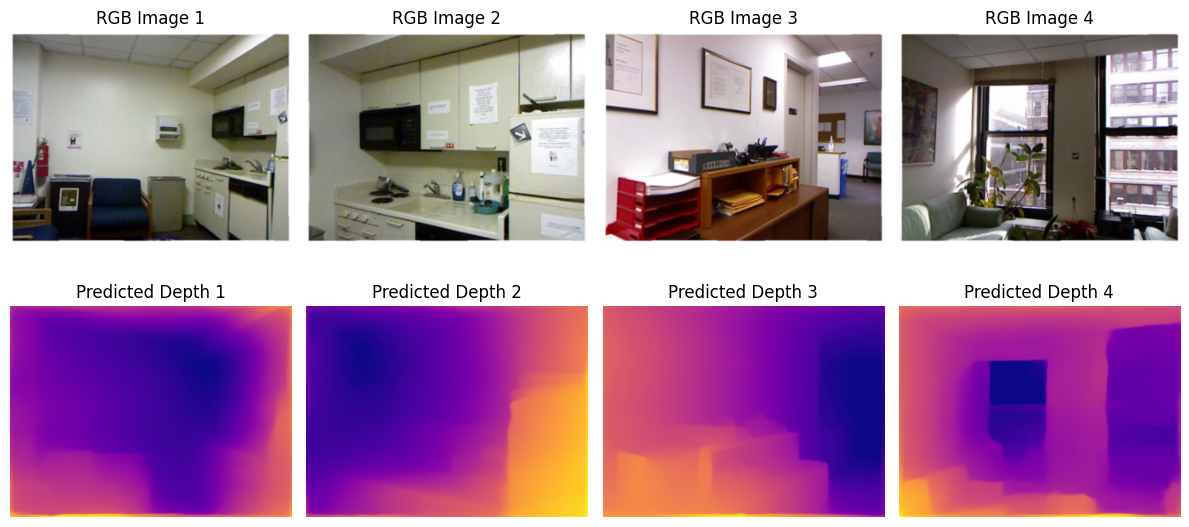

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchvision import transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MiDaS
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas.to(device)
midas.eval()

preprocess = T.Resize((256, 256))

def unnormalize_img(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Metrics
rmse_values, mae_values = [], []
abs_rel_values, sq_rel_values = [], []
delta1_values = []

sample_rgb_images, sample_gt_depths, sample_pred_depths = [], [], []

# Add tqdm total for better progress visualization
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader, desc="Evaluating", total=10)):
        color_images, gt_depth = batch
        color_images, gt_depth = color_images.to(device), gt_depth.to(device)
        batch_size = color_images.size(0)

        # Store samples for visualization
        if idx == 0:
            for i in range(min(8, batch_size)):
                sample_rgb_images.append(color_images[i].cpu())
                sample_gt_depths.append(gt_depth[i].cpu())

        # Resize for MiDaS
        resized_images = torch.stack([preprocess(img.cpu()) for img in color_images]).to(device)

        # Predict depth
        pred_depth = midas(resized_images)

        # Resize prediction back to original GT shape
        pred_depth = F.interpolate(
            pred_depth.unsqueeze(1),
            size=gt_depth.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze(1)

        # Store predictions for visualization
        if idx == 0:
            for i in range(min(8, batch_size)):
                sample_pred_depths.append(pred_depth[i].cpu())

        # Metric computation
        for i in range(batch_size):
            gt_sample = gt_depth[i].squeeze()
            pred_sample = pred_depth[i]

            valid_mask = gt_sample > 0
            if valid_mask.sum() > 0:
                gt_masked = gt_sample[valid_mask]
                pred_masked = pred_sample[valid_mask]

                scale = torch.median(gt_masked) / torch.median(pred_masked)
                pred_masked *= scale

                gt_np = gt_masked.cpu().numpy()
                pred_np = pred_masked.cpu().numpy()

                mae_values.append(mean_absolute_error(gt_np, pred_np))
                rmse_values.append(np.sqrt(mean_squared_error(gt_np, pred_np)))
                abs_rel_values.append(torch.mean(torch.abs(gt_masked - pred_masked) / gt_masked).item())
                sq_rel_values.append(torch.mean((gt_masked - pred_masked) ** 2 / gt_masked).item())
                thresh = torch.max(gt_masked / pred_masked, pred_masked / gt_masked)
                delta1_values.append((thresh < 1.25).float().mean().item())

        if idx >= 10:
            break

# Final metrics
if rmse_values:
    print("\nMiDaS Small Model Evaluation on NYU Depth Dataset:")
    print(f"Average RMSE: {np.mean(rmse_values):.4f}")
    print(f"Average MAE: {np.mean(mae_values):.4f}")
    print(f"Average AbsRel: {np.mean(abs_rel_values):.4f}")
    print(f"Average SqRel: {np.mean(sq_rel_values):.4f}")
    print(f"Average δ1: {np.mean(delta1_values):.4f}")

    # Visualization (only RGB and predicted depth)
    num_images = min(4, len(sample_rgb_images))
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        # RGB Image
        plt.subplot(2, num_images, i + 1)
        img = unnormalize_img(sample_rgb_images[i]).numpy().transpose(1, 2, 0)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"RGB Image {i+1}")
        plt.axis("off")

        # Predicted Depth
        plt.subplot(2, num_images, i + 1 + num_images)
        gt = sample_gt_depths[i].squeeze().numpy()
        pred = sample_pred_depths[i].squeeze().numpy()
        valid_mask = gt > 0
        if valid_mask.sum() > 0:
            scale = np.median(gt[valid_mask]) / np.median(pred[valid_mask])
            pred *= scale
        plt.imshow(pred, cmap='plasma')
        plt.title(f"Predicted Depth {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig('midas_depth_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No valid depth values were found in the batches.")

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------
# Dataset and Transforms
# -------------------------------
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, csv_filename, transform=None, depth_transform=None):
        csv_path = os.path.join(root_dir, "nyu_data", "data", csv_filename)
        df = pd.read_csv(csv_path, header=None)

        # Debug info
        print("CSV DataFrame shape:", df.shape)
        print("CSV DataFrame head:\n", df.head())

        # In case there's an extra index column, drop it.
        if df.shape[1] == 3:
            print("Dropping the extra index column from CSV.")
            df = df.iloc[:, 1:3]

        self.samples = df.reset_index(drop=True)
        print("Final CSV shape used:", self.samples.shape)

        self.root_dir = root_dir
        self.transform = transform
        self.depth_transform = depth_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_rel_path = self.samples.iloc[idx, 0]
        depth_rel_path = self.samples.iloc[idx, 1]

        color_path = os.path.join(self.root_dir, "nyu_data", color_rel_path)
        depth_path = os.path.join(self.root_dir, "nyu_data", depth_rel_path)

        color_image = Image.open(color_path).convert('RGB')
        depth_image = Image.open(depth_path).convert('L')

        if self.transform:
            color_image = self.transform(color_image)
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)
        else:
            depth_image = transforms.ToTensor()(depth_image)

        return color_image, depth_image

# -------------------------------
# Updated Transforms for Fine-tuning (256x256)
# -------------------------------
color_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

depth_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Assumes depth maps are stored as grayscale images.
])

# Define your dataset root (update this path accordingly)
dataset_root = path

# Create training and test dataset instances.
train_dataset = NYUDepthDataset(
    root_dir=dataset_root,
    csv_filename="nyu2_train.csv",
    transform=color_transforms,
    depth_transform=depth_transforms
)

test_dataset = NYUDepthDataset(
    root_dir=dataset_root,
    csv_filename="nyu2_test.csv",
    transform=color_transforms,
    depth_transform=depth_transforms
)

# Split training dataset into training and validation sets.
batch_size = 16
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders.
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Number of training samples:", len(train_subset))
print("Number of validation samples:", len(val_subset))
print("Number of test samples:", len(test_dataset))



CSV DataFrame shape: (50688, 2)
CSV DataFrame head:
                                               0  \
0   data/nyu2_train/living_room_0038_out/37.jpg   
1  data/nyu2_train/living_room_0038_out/115.jpg   
2    data/nyu2_train/living_room_0038_out/6.jpg   
3   data/nyu2_train/living_room_0038_out/49.jpg   
4  data/nyu2_train/living_room_0038_out/152.jpg   

                                              1  
0   data/nyu2_train/living_room_0038_out/37.png  
1  data/nyu2_train/living_room_0038_out/115.png  
2    data/nyu2_train/living_room_0038_out/6.png  
3   data/nyu2_train/living_room_0038_out/49.png  
4  data/nyu2_train/living_room_0038_out/152.png  
Final CSV shape used: (50688, 2)
CSV DataFrame shape: (654, 2)
CSV DataFrame head:
                                  0                               1
0  data/nyu2_test/00000_colors.png  data/nyu2_test/00000_depth.png
1  data/nyu2_test/00001_colors.png  data/nyu2_test/00001_depth.png
2  data/nyu2_test/00008_colors.png  data/nyu2_test/0000

In [17]:
# -------------------------------
# Load Pretrained MiDaS Model
# -------------------------------
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas.to(device)

# Optionally, freeze some layers if desired
# for name, param in midas.named_parameters():
#     if "some_layer_identifier" not in name:
#         param.requires_grad = False

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [18]:
for x, y in midas.named_parameters():
  print(x)

pretrained.layer1.0.weight
pretrained.layer1.1.weight
pretrained.layer1.1.bias
pretrained.layer1.3.0.conv_dw.weight
pretrained.layer1.3.0.bn1.weight
pretrained.layer1.3.0.bn1.bias
pretrained.layer1.3.0.conv_pw.weight
pretrained.layer1.3.0.bn2.weight
pretrained.layer1.3.0.bn2.bias
pretrained.layer1.4.0.conv_pw.weight
pretrained.layer1.4.0.bn1.weight
pretrained.layer1.4.0.bn1.bias
pretrained.layer1.4.0.conv_dw.weight
pretrained.layer1.4.0.bn2.weight
pretrained.layer1.4.0.bn2.bias
pretrained.layer1.4.0.conv_pwl.weight
pretrained.layer1.4.0.bn3.weight
pretrained.layer1.4.0.bn3.bias
pretrained.layer1.4.1.conv_pw.weight
pretrained.layer1.4.1.bn1.weight
pretrained.layer1.4.1.bn1.bias
pretrained.layer1.4.1.conv_dw.weight
pretrained.layer1.4.1.bn2.weight
pretrained.layer1.4.1.bn2.bias
pretrained.layer1.4.1.conv_pwl.weight
pretrained.layer1.4.1.bn3.weight
pretrained.layer1.4.1.bn3.bias
pretrained.layer1.4.2.conv_pw.weight
pretrained.layer1.4.2.bn1.weight
pretrained.layer1.4.2.bn1.bias
pretrained

In [32]:
midas.train()

# -------------------------------
# Define Loss and Optimizer
# -------------------------------
criterion = nn.L1Loss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, midas.parameters()), lr=1e-4)

# -------------------------------
# Training and Validation Loop (Updated)
# -------------------------------
num_epochs = 1  # Adjust as needed

for epoch in range(num_epochs):
    midas.train()
    train_loss = 0.0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    for color_images, gt_depth in tqdm(train_loader, desc="Training"):
        # Move to device and adjust ground truth shape (removing the channel dimension)
        color_images = color_images.to(device)
        gt_depth = gt_depth.to(device).squeeze(1)  # Now gt_depth is (batch, H, W)

        optimizer.zero_grad()

        # Forward pass: predict depth
        pred_depth = midas(color_images)
        # Resize prediction to match ground truth dimensions.
        pred_depth = F.interpolate(pred_depth.unsqueeze(1),
                                   size=gt_depth.shape[1:],  # gt_depth is (batch, H, W)
                                   mode='bilinear',
                                   align_corners=False).squeeze(1)

        # Compute loss on valid regions (where GT depth > 0)
        valid_mask = gt_depth > 0
        if valid_mask.sum() > 0:
            loss = criterion(pred_depth[valid_mask], gt_depth[valid_mask])
        else:
            continue

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * color_images.size(0)

    train_loss /= len(train_subset)
    print(f"Training Loss: {train_loss:.4f}")

    # Validation phase.
    midas.eval()
    val_loss = 0.0
    with torch.no_grad():
        for color_images, gt_depth in tqdm(val_loader, desc="Validation"):
            color_images = color_images.to(device)
            gt_depth = gt_depth.to(device).squeeze(1)

            pred_depth = midas(color_images)
            pred_depth = F.interpolate(pred_depth.unsqueeze(1),
                                       size=gt_depth.shape[1:],
                                       mode='bilinear',
                                       align_corners=False).squeeze(1)

            valid_mask = gt_depth > 0
            if valid_mask.sum() > 0:
                loss = criterion(pred_depth[valid_mask], gt_depth[valid_mask])
            else:
                continue

            val_loss += loss.item() * color_images.size(0)

    val_loss /= len(val_subset)
    print(f"Validation Loss: {val_loss:.4f}")

# -------------------------------
# Save the Fine-Tuned Model
# -------------------------------
torch.save(midas.state_dict(), "midas_finetuned.pth")
print("Finetuning complete. Model saved as midas_finetuned.pth")


Epoch 1/1


Training: 100%|██████████| 2535/2535 [11:34<00:00,  3.65it/s]


Training Loss: 0.7933


Validation: 100%|██████████| 634/634 [01:48<00:00,  5.86it/s]


Validation Loss: 0.2907
Finetuning complete. Model saved as midas_finetuned.pth


In [24]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchvision import transforms as T

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Evaluating: 100%|██████████| 634/634 [02:10<00:00,  4.87it/s]



📊 MiDaS Evaluation Metrics:
Average RMSE     : 0.2778
Average MAE      : 0.2252
Average AbsRel   : 0.9818
Average SqRel    : 0.5126
Average δ1 (<1.25): 0.2140


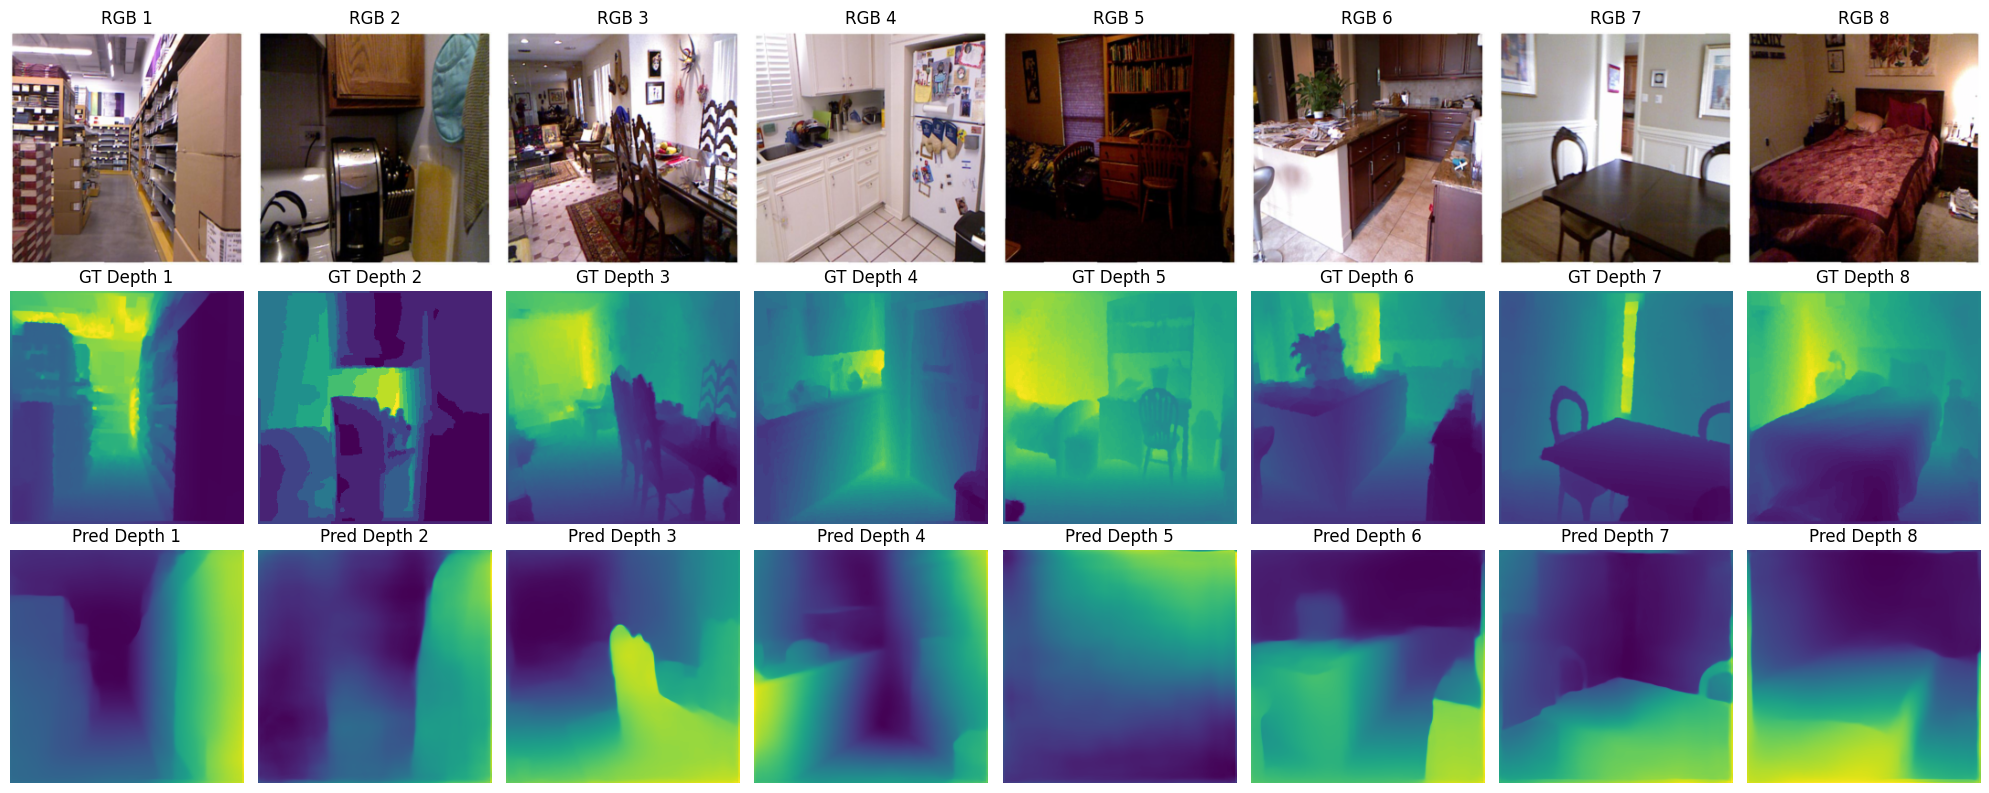

In [36]:
# Path to your finetuned model
model_path = "/content/midas_finetuned.pth"

# Load base model architecture (MiDaS small used here for speed)
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")

# Load your fine-tuned weights
checkpoint = torch.load(model_path, map_location=device)

# If saved using `model.state_dict()`
if "state_dict" in checkpoint:
    midas.load_state_dict(checkpoint["state_dict"])
else:
    midas.load_state_dict(checkpoint)

# Move model to device
midas = midas.to(device)
midas.eval()

# -------------------------------
# Image Preprocessing & Denormalization
# -------------------------------
preprocess = T.Compose([
    T.Resize((256, 256)),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

# -------------------------------
# Metrics Initialization
# -------------------------------
rmse_values, mae_values = [], []
abs_rel_values, sq_rel_values = [], []
delta1_values = []

# -------------------------------
# Storage for Visualization
# -------------------------------
all_rgb_images, all_gt_depths, all_pred_depths = [], [], []

with torch.no_grad():
    for idx, (color_images, gt_depth) in enumerate(tqdm(val_loader, desc="Evaluating")):
        color_images = color_images.to(device)
        gt_depth = gt_depth.to(device)  # (B, 1, H, W)
        batch_size = color_images.shape[0]

        # Denormalized images for visualization
        for i in range(batch_size):
            if len(all_rgb_images) < 8:
                all_rgb_images.append(denormalize(color_images[i]).cpu())
                all_gt_depths.append(gt_depth[i].squeeze().cpu())

        # Apply MiDaS preprocessing
        resized_images = torch.stack([preprocess(img) for img in color_images]).to(device)

        # Inference
        pred_depth = midas(resized_images)  # (B, H, W)
        pred_depth = F.interpolate(pred_depth.unsqueeze(1),
                                   size=gt_depth.shape[2:],
                                   mode='bilinear',
                                   align_corners=False).squeeze(1)  # (B, H, W)

        # Save predictions for visualization
        if idx == 0:
            for i in range(min(batch_size, 8)):
                all_pred_depths.append(pred_depth[i].cpu())

        # Compute metrics
        for i in range(batch_size):
            gt_sample = gt_depth[i].squeeze()
            pred_sample = pred_depth[i]

            mask = (gt_sample > 0) & torch.isfinite(gt_sample) & torch.isfinite(pred_sample)
            if mask.sum() == 0:
                continue

            gt_masked = gt_sample[mask]
            pred_masked = pred_sample[mask]

            # Median scaling
            pred_median = torch.median(pred_masked)
            if pred_median.item() > 1e-6:
                scale = torch.median(gt_masked) / pred_median
                pred_masked *= scale

            # Convert to numpy
            gt_np = gt_masked.cpu().numpy()
            pred_np = pred_masked.cpu().numpy()

            if np.isnan(gt_np).any() or np.isnan(pred_np).any():
                continue

            # Metrics
            mae = mean_absolute_error(gt_np, pred_np)
            rmse = np.sqrt(mean_squared_error(gt_np, pred_np))

            gt_eps = gt_masked.clone()
            gt_eps[gt_eps == 0] = 1e-8
            abs_rel = torch.mean(torch.abs(gt_masked - pred_masked) / gt_eps).item()
            sq_rel = torch.mean(((gt_masked - pred_masked) ** 2) / gt_eps).item()

            thresh = torch.max(gt_masked / pred_masked, pred_masked / gt_masked)
            delta1 = (thresh < 1.25).float().mean().item()

            rmse_values.append(rmse)
            mae_values.append(mae)
            abs_rel_values.append(abs_rel)
            sq_rel_values.append(sq_rel)
            delta1_values.append(delta1)

# -------------------------------
# Print Average Metrics
# -------------------------------
if rmse_values:
    print("\n📊 MiDaS Evaluation Metrics:")
    print(f"Average RMSE     : {np.mean(rmse_values):.4f}")
    print(f"Average MAE      : {np.mean(mae_values):.4f}")
    print(f"Average AbsRel   : {np.mean(abs_rel_values):.4f}")
    print(f"Average SqRel    : {np.mean(sq_rel_values):.4f}")
    print(f"Average δ1 (<1.25): {np.mean(delta1_values):.4f}")
else:
    print("⚠️ No valid depth values found in any batch!")

# -------------------------------
# Visualize Results
# -------------------------------
if all_rgb_images and all_pred_depths:
    fig, axes = plt.subplots(3, 8, figsize=(20, 8))
    cmap = plt.cm.viridis

    for i in range(len(all_rgb_images)):
        # RGB
        rgb_img = all_rgb_images[i].permute(1, 2, 0).numpy()
        rgb_img = np.clip(rgb_img, 0, 1)
        axes[0, i].imshow(rgb_img)
        axes[0, i].set_title(f"RGB {i+1}")
        axes[0, i].axis("off")

        # Ground Truth
        gt_img = all_gt_depths[i].numpy()
        axes[1, i].imshow(gt_img, cmap=cmap)
        axes[1, i].set_title(f"GT Depth {i+1}")
        axes[1, i].axis("off")

        # Prediction
        pred_img = all_pred_depths[i].numpy()
        valid_mask = gt_img > 0
        if np.median(pred_img[valid_mask]) > 1e-6:
            scale = np.median(gt_img[valid_mask]) / np.median(pred_img[valid_mask])
            pred_img *= scale
        axes[2, i].imshow(pred_img, cmap=cmap)
        axes[2, i].set_title(f"Pred Depth {i+1}")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.savefig('midas_depth_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Not enough valid samples to visualize.")